In [618]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import yfinance as yf
import datetime

msft = yf.Ticker("C")
print(msft)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


yfinance.Ticker object <XBI>


In [619]:
msft.info

{'longBusinessSummary': 'In seeking to track the performance of the S&P Biotechnology Select Industry Index (the "index"), the fund employs a sampling strategy. It generally invests substantially all, but at least 80%, of its total assets in the securities comprising the index. The index represents the biotechnology segment of the S&P Total Market Index ("S&P TMI").',
 'maxAge': 86400,
 'priceHint': 2,
 'previousClose': 95.48,
 'open': 96.83,
 'dayLow': 96.6699,
 'dayHigh': 98.77,
 'regularMarketPreviousClose': 95.48,
 'regularMarketOpen': 96.83,
 'regularMarketDayLow': 96.6699,
 'regularMarketDayHigh': 98.77,
 'volume': 14557229,
 'regularMarketVolume': 14557229,
 'averageVolume': 9163375,
 'averageVolume10days': 7489080,
 'averageDailyVolume10Day': 7489080,
 'bidSize': 1000,
 'askSize': 1100,
 'yield': 0.0014,
 'totalAssets': 7125551616,
 'fiftyTwoWeekLow': 63.8,
 'fiftyTwoWeekHigh': 103.52,
 'fiftyDayAverage': 91.2666,
 'twoHundredDayAverage': 85.50625,
 'navPrice': 95.505,
 'curren

In [620]:
df = msft.history(period="5y")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2019-07-12 00:00:00-04:00,85.667754,85.996481,84.731383,85.488449,3681600,0.0,0.0,0.0
2019-07-15 00:00:00-04:00,85.737470,86.175773,85.139790,85.847046,2240600,0.0,0.0,0.0
2019-07-16 00:00:00-04:00,85.966588,85.966588,84.850912,85.129829,2369700,0.0,0.0,0.0
2019-07-17 00:00:00-04:00,85.080023,85.737470,84.332921,85.209518,3434700,0.0,0.0,0.0
2019-07-18 00:00:00-04:00,84.990367,86.584184,84.970448,86.454689,3147700,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2024-07-05 00:00:00-04:00,90.860001,91.919998,90.279999,91.709999,5557900,0.0,0.0,0.0
2024-07-08 00:00:00-04:00,92.860001,93.680000,92.440002,93.230003,9007600,0.0,0.0,0.0
2024-07-09 00:00:00-04:00,93.389999,94.540001,92.849998,94.370003,7651400,0.0,0.0,0.0


In [621]:
df = df[['Close']]
df

,Close
Date,
2019-07-12 00:00:00-04:00,85.488449
2019-07-15 00:00:00-04:00,85.847046
2019-07-16 00:00:00-04:00,85.129829
2019-07-17 00:00:00-04:00,85.209518
2019-07-18 00:00:00-04:00,86.454689
...,...
2024-07-05 00:00:00-04:00,91.709999
2024-07-08 00:00:00-04:00,93.230003
2024-07-09 00:00:00-04:00,94.370003


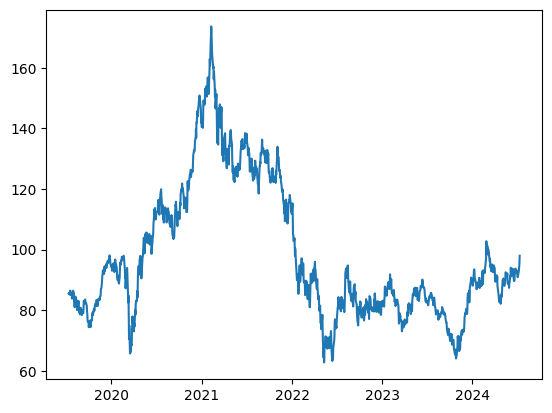

In [622]:
plt.plot(df.index, df['Close'])

In [623]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)


    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(df, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2019-07-23 00:00:00-04:00,84.980415,85.568138,85.279251,86.454689,85.209518,85.129829,85.847046,85.488449
2019-07-24 00:00:00-04:00,85.747429,84.980415,85.568138,85.279251,86.454689,85.209518,85.129829,85.847046
2019-07-25 00:00:00-04:00,83.804970,85.747429,84.980415,85.568138,85.279251,86.454689,85.209518,85.129829
2019-07-26 00:00:00-04:00,85.319092,83.804970,85.747429,84.980415,85.568138,85.279251,86.454689,85.209518
2019-07-29 00:00:00-04:00,85.129829,85.319092,83.804970,85.747429,84.980415,85.568138,85.279251,86.454689
...,...,...,...,...,...,...,...,...
2024-07-05 00:00:00-04:00,91.709999,90.870003,91.360001,93.040001,92.709999,92.860001,92.190002,93.080002
2024-07-08 00:00:00-04:00,93.230003,91.709999,90.870003,91.360001,93.040001,92.709999,92.860001,92.190002
2024-07-09 00:00:00-04:00,94.370003,93.230003,91.709999,90.870003,91.360001,93.040001,92.709999,92.860001


In [624]:
shifted_df_np = shifted_df.to_numpy()
shifted_df_np

array([[84.98041534, 85.56813812, 85.2792511 , ..., 85.12982941,
        85.8470459 , 85.4884491 ],
       [85.74742889, 84.98041534, 85.56813812, ..., 85.20951843,
        85.12982941, 85.8470459 ],
       [83.80496979, 85.74742889, 84.98041534, ..., 86.45468903,
        85.20951843, 85.12982941],
       ...,
       [94.37000275, 93.23000336, 91.70999908, ..., 93.04000092,
        92.70999908, 92.86000061],
       [95.48000336, 94.37000275, 93.23000336, ..., 91.36000061,
        93.04000092, 92.70999908],
       [97.95999908, 95.48000336, 94.37000275, ..., 90.87000275,
        91.36000061, 93.04000092]])

In [625]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_np = scaler.fit_transform(shifted_df_np)

shifted_df_np

array([[-0.59879898, -0.58820669, -0.59341318, ..., -0.59610615,
        -0.58318004, -0.58964289],
       [-0.5849754 , -0.59879898, -0.58820669, ..., -0.59466995,
        -0.59610615, -0.58318004],
       [-0.61998357, -0.5849754 , -0.59879898, ..., -0.57222873,
        -0.59466995, -0.59610615],
       ...,
       [-0.42957419, -0.45011994, -0.47751437, ..., -0.45354428,
        -0.45949177, -0.45678835],
       [-0.40956909, -0.42957419, -0.45011994, ..., -0.48382226,
        -0.45354428, -0.45949177],
       [-0.36487311, -0.40956909, -0.42957419, ..., -0.49265329,
        -0.48382226, -0.45354428]])

In [626]:
X = shifted_df_np[:, 1:]
y = shifted_df_np[:, 0]

X.shape, y.shape
print(X)

[[-0.58820669 -0.59341318 -0.57222873 ... -0.59610615 -0.58318004
  -0.58964289]
 [-0.59879898 -0.58820669 -0.59341318 ... -0.59466995 -0.59610615
  -0.58318004]
 [-0.5849754  -0.59879898 -0.58820669 ... -0.57222873 -0.59466995
  -0.59610615]
 ...
 [-0.45011994 -0.47751437 -0.49265329 ... -0.45354428 -0.45949177
  -0.45678835]
 [-0.42957419 -0.45011994 -0.47751437 ... -0.48382226 -0.45354428
  -0.45949177]
 [-0.40956909 -0.42957419 -0.45011994 ... -0.49265329 -0.48382226
  -0.45354428]]


In [627]:
X = dc(np.flip(X, axis=1))
X
split_index = int(len(X) * .95)
split_index

1188

In [628]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1188, 7, 1]),
 torch.Size([63, 7, 1]),
 torch.Size([1188, 1]),
 torch.Size([63, 1]))

In [629]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
train_dataset

In [630]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [631]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 16, 2)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 16, num_layers=2, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [632]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print() 
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [633]:
learning_rate = 0.002
num_epochs = 30
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1



Val Loss: 0.004
***************************************************

Epoch: 2

Val Loss: 0.004
***************************************************

Epoch: 3

Val Loss: 0.003
***************************************************

Epoch: 4

Val Loss: 0.002
***************************************************

Epoch: 5

Val Loss: 0.002
***************************************************

Epoch: 6

Val Loss: 0.002
***************************************************

Epoch: 7

Val Loss: 0.002
***************************************************

Epoch: 8

Val Loss: 0.002
***************************************************

Epoch: 9

Val Loss: 0.002
***************************************************

Epoch: 10

Val Loss: 0.002
***************************************************

Epoch: 11

Val Loss: 0.002
***************************************************

Epoch: 12

Val Loss: 0.002
***************************************************

Epoch: 13

Val Loss: 0.001
*******************************

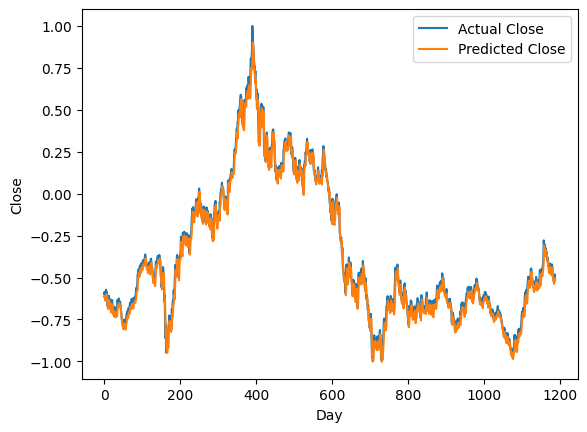

In [634]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')

plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [635]:
print(y_train.shape)
print(predicted.shape)
train_predictions = predicted.flatten()
print(train_predictions.shape)

torch.Size([1188, 1])
(1188, 1)
(1188,)


In [636]:

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([84.17971777, 83.73806215, 84.31213871, ..., 88.72122054,
       89.03074955, 90.12244187])

In [637]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([84.98041472, 85.74742768, 83.80497045, ..., 90.28746867,
       91.52592534, 89.83802125])

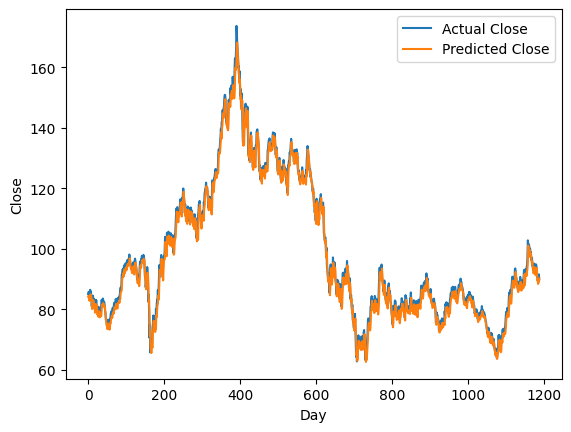

In [638]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [639]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([88.7917304 , 89.65860806, 87.17665783, 85.13750751, 84.28928916,
       83.41864126, 82.2797748 , 81.53853829, 82.21411332, 83.16649246,
       82.64131309, 81.03042747, 81.83681945, 83.82922558, 83.35736185,
       85.49540456, 86.79596745, 88.335189  , 89.0711505 , 88.99434371,
       87.81285715, 87.53014967, 86.83984429, 88.25158257, 89.32188381,
       91.01702078, 91.21341157, 89.91009542, 90.66000511, 90.27970332,
       90.69649032, 88.30803014, 87.43286128, 87.69172373, 86.34737991,
       87.35273073, 87.74963309, 89.74636505, 89.83775337, 92.34409267,
       91.61572288, 90.09451904, 90.44172717, 91.03398184, 92.31123547,
       92.48280063, 90.59771038, 89.26369003, 88.39395493, 88.48656691,
       90.73514672, 92.39387454, 91.91489368, 90.9510104 , 91.43748375,
       91.46996558, 91.74144175, 90.30520858, 89.60913541, 90.32459217,
       91.83068038, 93.03454356, 94.11713443])

In [640]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([91.16636641, 88.04026797, 86.24250807, 85.50343448, 84.54462281,
       83.376084  , 82.72689063, 83.64574451, 84.5845806 , 83.83550929,
       82.11765174, 83.38606187, 85.41353772, 84.51466273, 87.22129202,
       88.23002613, 89.86798794, 90.4672473 , 90.31742874, 88.99906972,
       88.86923832, 88.03028017, 89.76811331, 90.6669916 , 92.49471323,
       92.47473929, 91.0664984 , 92.15513651, 91.45600913, 92.05526022,
       89.20881008, 88.71942141, 89.019042  , 87.37110232, 88.84925943,
       89.019042  , 91.30619883, 91.05650399, 94.00283868, 92.70445194,
       91.27623049, 91.8754882 , 92.34490128, 93.70320817, 93.70320817,
       91.63578776, 90.47722683, 89.58833302, 89.7780978 , 92.26499893,
       93.73999765, 93.08000125, 92.19000284, 92.86000025, 92.70999979,
       93.04000047, 91.36000063, 90.87000343, 91.70999839, 93.23000337,
       94.37000255, 95.48000362, 97.95999929])

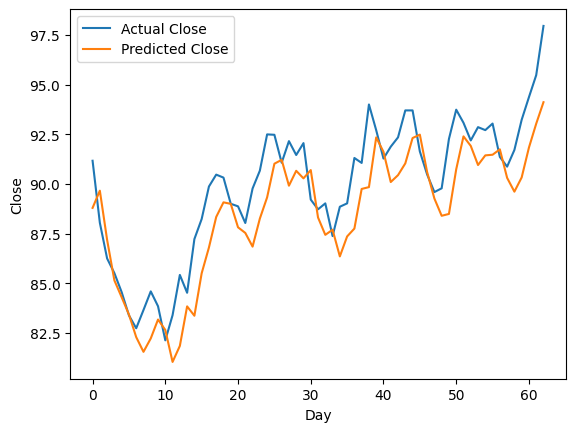

In [641]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [642]:
test_predictions

array([88.7917304 , 89.65860806, 87.17665783, 85.13750751, 84.28928916,
       83.41864126, 82.2797748 , 81.53853829, 82.21411332, 83.16649246,
       82.64131309, 81.03042747, 81.83681945, 83.82922558, 83.35736185,
       85.49540456, 86.79596745, 88.335189  , 89.0711505 , 88.99434371,
       87.81285715, 87.53014967, 86.83984429, 88.25158257, 89.32188381,
       91.01702078, 91.21341157, 89.91009542, 90.66000511, 90.27970332,
       90.69649032, 88.30803014, 87.43286128, 87.69172373, 86.34737991,
       87.35273073, 87.74963309, 89.74636505, 89.83775337, 92.34409267,
       91.61572288, 90.09451904, 90.44172717, 91.03398184, 92.31123547,
       92.48280063, 90.59771038, 89.26369003, 88.39395493, 88.48656691,
       90.73514672, 92.39387454, 91.91489368, 90.9510104 , 91.43748375,
       91.46996558, 91.74144175, 90.30520858, 89.60913541, 90.32459217,
       91.83068038, 93.03454356, 94.11713443])

In [643]:

test_dates = df.index[-len(new_y_test):]

# Create dataframe with dates, actual and predicted values
test_results_df = pd.DataFrame({
    'Date': test_dates,
    'Actual': new_y_test,
    'Predicted': test_predictions
})
print("Test Results:")
print(test_results_df)



Test Results:
                        Date     Actual  Predicted
0  2024-04-11 00:00:00-04:00  91.166366  88.791730
1  2024-04-12 00:00:00-04:00  88.040268  89.658608
2  2024-04-15 00:00:00-04:00  86.242508  87.176658
3  2024-04-16 00:00:00-04:00  85.503434  85.137508
4  2024-04-17 00:00:00-04:00  84.544623  84.289289
..                       ...        ...        ...
58 2024-07-05 00:00:00-04:00  91.709998  89.609135
59 2024-07-08 00:00:00-04:00  93.230003  90.324592
60 2024-07-09 00:00:00-04:00  94.370003  91.830680
61 2024-07-10 00:00:00-04:00  95.480004  93.034544
62 2024-07-11 00:00:00-04:00  97.959999  94.117134

[63 rows x 3 columns]


In [644]:
def predict_future_dates(model, last_known_data, scaler, num_predictions):
    model.eval()
    predictions = []
    data = last_known_data
    for _ in range(num_predictions):
        input_data = torch.tensor(data.reshape(
            1, lookback, 1)).float().to(device)
        with torch.no_grad():
            pred = model(input_data).cpu().numpy().flatten()
        predictions.append(pred[0])
        data = np.append(data[1:], pred)
    predictions = np.array(predictions).reshape(-1, 1)
    dummies = np.zeros((predictions.shape[0], lookback + 1))
    dummies[:, 0] = predictions.flatten()
    predictions = scaler.inverse_transform(dummies)[:, 0]
    return predictions


# Predict future dates
num_future_predictions = 2
last_known_data = X_test[-1].cpu().numpy()
future_predictions = predict_future_dates(
    model, last_known_data, scaler, num_future_predictions)

# Create future dates
last_date = test_results_df['Date'].iloc[-1]
future_dates = pd.date_range(
    start=last_date, periods=num_future_predictions)

print(future_dates)
future_predictions

DatetimeIndex(['2024-07-11 00:00:00-04:00', '2024-07-12 00:00:00-04:00'], dtype='datetime64[ns, America/New_York]', freq='D')


array([94.11713443, 93.00721273])

In [645]:
predictions = pd.DataFrame(future_predictions, index=future_dates, columns=['Predicted'])
predictions['Percent Change'] = predictions['Predicted'].pct_change()

predictions

,Predicted,Percent Change
2024-07-11 00:00:00-04:00,94.117134,NaN
2024-07-12 00:00:00-04:00,93.007213,-0.011793
